### Connect to Google Drive

In [1]:
# Import libraries for importing files from Google drive to Colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authorize Google SDK to access Google Drive from Colab

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
download = drive.CreateFile({'id': '#redacted document id'})
download.GetContentFile('spam.csv')

### Import Necessary Libraries

In [3]:
import os
import re
import tqdm
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import urllib.request
from typing import List
from collections import Counter
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Pre-processing

In [4]:
# read data from spam.csv

sms_data = pd.read_csv('./spam.csv', usecols=[0,1], encoding="latin")
sms_data.columns = ["label", "content"]
sms_data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


開始進行模型建模之前，我們先對資料進行前處理。在前處理部分，我們會將文字轉化為小寫，移除標點符號，最後除了處理過的文本外，也輸出word-index、index-word、詞頻(word-frequency)、與總文本字數

<font color='green'>Objective: preprocessing (converting all texts to lower case, remove punctuation, and output word-index, index-word, word frequency and corpus length)</font>

Note: Subsampling 
Subsampling is a technique that is used to remove the most frequent words in a given corpus (usually the words with minimal semantic meaning or stop words, such as 'the', 'a', etc.) 

$p(w_i) = (\sqrt{\frac{z(w_i)}{t}}+ 1)\frac{t}{z(w_i)}$

$\text{, where } z(w_i) \text{ is the frequency of the word, while t is a hyperparameter that is adjustable (normally set at 0.001, 0.0001, or 0.00001)}$

In [5]:
class PreProcessor():
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    min_freq: int
        minimum frequency of a word to be kept
    do_subsampling: bool
        whether to do subsampling
    '''
    
    def __init__(self, only_word: bool=False, min_freq: int=5, do_subsampling: bool=True, t: float=1e-5):
        self.only_word = only_word
        self.min_freq = min_freq
        self.do_subsampling = do_subsampling
        self.t = t
    
    def process(self, corpus: List[str]):
        
        word_dic = set()
        counter = Counter()
        processed_sentence = []
        
        for sentence in corpus:
            #將所有字詞轉為小寫
            sentence = sentence.lower()
            #移除標點符號(可以依據使用狀況決定是否要移除標點符號)
            
            if self.only_word:
                sentence = [word for word in re.findall(r"[a-zA-Z]*", sentence) if word != ""]
            else:
                punctuation_list = ['.', ',', '!', '?']
                for pun in punctuation_list:
                    sentence = sentence.replace(pun, ' '+pun)
                sentence = sentence.split(' ')
        
            #計算字詞頻率
            counter.update(sentence)
            processed_sentence.append(sentence)
    
        #移除頻率過小的字詞
        word_cnt = dict(filter(lambda x: x[1] > self.min_freq, counter.items()))
        #添加字詞到字典中
        
        self.word2idx = {word: idx for idx, word in enumerate(word_cnt.keys(), 0)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.word_frequency = word_cnt.copy()
        
        #將文本轉為ID型式與移除文本中頻率過小的文字
        self.processed_corpus = [[self.word2idx[word] for word in line if word in self.word2idx] for line in processed_sentence]
        self.total_num_words = sum([len(line) for line in self.processed_corpus])
        print(f"Before subsampling: {self.total_num_words} words")
        
        # 進行二次採樣(subsampling)
        if self.do_subsampling:
            self.processed_corpus = [[idx for idx in line if self.subsampling(idx)] for line in self.processed_corpus]
            self.total_num_words = sum([len(line) for line in self.processed_corpus])
            counter = Counter([self.idx2word[idx] for line in self.processed_corpus for idx in line])
            word_cnt = dict(counter.items())
            self.word_frequency = word_cnt.copy()
            print(f"After subsampling: {self.total_num_words} words")
        
        self.processed_corpus = [[idx for idx in line] for line in self.processed_corpus if len(line) != 0]
        
        return self.processed_corpus, self.word2idx, self.idx2word, self.word_frequency, self.total_num_words
    
    def subsampling(self, idx):
        
        p = self.t / self.word_frequency[self.idx2word[idx]] * self.total_num_words
        p_w = math.sqrt(p) + p
        
        return random.uniform(0, 1) < p_w

In [6]:
# 在前處理會透過subsampling來降低高頻詞的次數
pre_processor = PreProcessor(True, 5, True, 1e-4)
corpus, word2idx, idx2word, word2freq, total_num_words = pre_processor.process(sms_data['content'].values)

Before subsampling: 76478 words
After subsampling: 28894 words


### 自定義Dataset與Collate function

In [7]:
class GetAllDataset(Dataset):
    
    def __init__(self, corpus, word2freq, word2idx, idx2word, window_size, num_negatives):
        self.corpus = corpus
        self.word2freq = word2freq
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window_size = window_size
        self.num_negatives = num_negatives
        
        self.all_targets, self.all_contexts = self._get_all_contexts_targets()
        self.all_negatives = self._get_all_negatives()
        
    def __len__(self):
        return len(self.all_targets)
    
    def __getitem__(self, idx):
        
        # 返回目標字詞、上下文與負採樣的目標
        return (self.all_targets[idx], self.all_contexts[idx], self.all_negatives[idx])
        
    
    def _get_all_contexts_targets(self):
        all_targets = []
        all_contexts = []
        
        for line in self.corpus:
            if len(line) < 2*self.window_size + 1:
                continue
            
            all_targets += [[word] for word in line[self.window_size:-self.window_size]]
            for index in range(self.window_size, len(line) - self.window_size):
                indices = list(range(max(0, index - self.window_size), min(len(line), index + self.window_size + 1)))
                indices.remove(index)
                all_contexts.append([line[idx] for idx in indices])
                               
        return all_targets, all_contexts
                               
    
    def _get_all_negatives(self):
        
        cur_exists_words = list(self.word2freq.keys())
        sampling_weights = [self.word2freq[word]**0.75 for word in self.word2freq]
        population = list(range(len(sampling_weights)))
        
        all_negatives = []
        neg_candidate = []
        i = 0
        for word in self.all_targets:
            negatives = []
            while len(negatives) < self.num_negatives:
                if i == len(neg_candidate):
                    neg_candidate = random.choices(population, sampling_weights, k=int(1e5))
                    neg_candidate = list(map(lambda x: self.word2idx[cur_exists_words[x]], neg_candidate))
                    i = 0
                if neg_candidate[i] != word[0]:
                    negatives.append(neg_candidate[i])
                i += 1
            all_negatives.append(negatives)        
        
        return all_negatives
    

def all_collate(data):
    contexts = []
    target_negative = []
    labels = []
    for target, context, negative in data:
        target_negative += [target + negative]
        labels += [[1] * len(target) + [0] * len(negative)]
        contexts += [context]
    
    return torch.tensor(contexts), torch.tensor(target_negative), torch.tensor(labels)

In [8]:
#查看資料產出
d_set = GetAllDataset(corpus, word2freq, word2idx, idx2word, window_size=1, num_negatives=3)
dataloader = DataLoader(d_set, batch_size=2, shuffle=True, collate_fn=all_collate)

#透過next與iter取出資料
next(iter(dataloader))

(tensor([[ 230,  509],
         [1075,  569]]), tensor([[1197, 1434,  272, 1514],
         [  66,  630,   38,  117]]), tensor([[1, 0, 0, 0],
         [1, 0, 0, 0]]))

### 自定義模型

In [9]:
class CBOW(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(CBOW, self).__init__()
        
        self.in_embedding = nn.Embedding(vocab_size, embed_size)
        self.out_embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, contexts, targets):
        v = torch.mean(self.in_embedding(contexts), dim=1) # [batch * (# per docs), embed_size]
        u = self.out_embedding(targets)
        
        # do dot product to get output
        pred = torch.matmul(v[:,None,:], u.permute(0,2,1))
        
        return pred.squeeze(dim=1)

### 設置超參數

In [16]:
use_cuda = torch.cuda.is_available()
verbose = True
num_epochs = 125
batch_size = 512
embed_size = 100
lr = 0.01
model = CBOW(len(word2idx), embed_size)
if use_cuda:
    model.cuda()
    
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
dataset = GetAllDataset(corpus, word2freq, word2idx, idx2word, 2, 5)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=all_collate)

### 開始訓練

In [17]:
# training
lst_loss = []
model.train()
for epc in tqdm.tqdm(range(num_epochs)):
    batch_loss = 0
    for i, (contexts, target_negative, labels) in enumerate(loader, 1):
        optimizer.zero_grad()
        
        if use_cuda:
            contexts = contexts.cuda()
            target_negative = target_negative.cuda()
            labels = labels.cuda()
        
        pred = model(contexts, target_negative)
        loss = criterion(pred.float(), labels.float())
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 500 == 0:
            print(f"Epoch: {epc + 1}/{num_epochs}, Batch: {i+1}/{len(dataset)/batch_size} Loss: {batch_loss / i:.5f}")
    
    if verbose:
        print(f"Epoch: {epc + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")
    
    lst_loss.append(batch_loss/i)

  2%|▏         | 2/125 [00:00<00:11, 11.16it/s]

Epoch: 1/125, Loss: 2.09010
Epoch: 2/125, Loss: 1.51764
Epoch: 3/125, Loss: 1.13898


  5%|▍         | 6/125 [00:00<00:10, 10.97it/s]

Epoch: 4/125, Loss: 0.84634
Epoch: 5/125, Loss: 0.62403
Epoch: 6/125, Loss: 0.45651


  6%|▋         | 8/125 [00:00<00:10, 11.09it/s]

Epoch: 7/125, Loss: 0.33000
Epoch: 8/125, Loss: 0.24093
Epoch: 9/125, Loss: 0.17955


 10%|▉         | 12/125 [00:01<00:10, 11.12it/s]

Epoch: 10/125, Loss: 0.13667
Epoch: 11/125, Loss: 0.10646
Epoch: 12/125, Loss: 0.08574


 11%|█         | 14/125 [00:01<00:10, 11.09it/s]

Epoch: 13/125, Loss: 0.07051
Epoch: 14/125, Loss: 0.05860
Epoch: 15/125, Loss: 0.04999


 14%|█▍        | 18/125 [00:01<00:09, 11.00it/s]

Epoch: 16/125, Loss: 0.04345
Epoch: 17/125, Loss: 0.03790
Epoch: 18/125, Loss: 0.03372


 16%|█▌        | 20/125 [00:01<00:09, 11.10it/s]

Epoch: 19/125, Loss: 0.03003
Epoch: 20/125, Loss: 0.02710
Epoch: 21/125, Loss: 0.02464


 19%|█▉        | 24/125 [00:02<00:08, 11.47it/s]

Epoch: 22/125, Loss: 0.02243
Epoch: 23/125, Loss: 0.02050
Epoch: 24/125, Loss: 0.01889


 21%|██        | 26/125 [00:02<00:08, 11.44it/s]

Epoch: 25/125, Loss: 0.01742
Epoch: 26/125, Loss: 0.01611
Epoch: 27/125, Loss: 0.01503


 22%|██▏       | 28/125 [00:02<00:08, 11.24it/s]

Epoch: 28/125, Loss: 0.01401
Epoch: 29/125, Loss: 0.01308


 26%|██▌       | 32/125 [00:02<00:08, 10.43it/s]

Epoch: 30/125, Loss: 0.01223
Epoch: 31/125, Loss: 0.01150
Epoch: 32/125, Loss: 0.01081


 27%|██▋       | 34/125 [00:03<00:08, 10.68it/s]

Epoch: 33/125, Loss: 0.01020
Epoch: 34/125, Loss: 0.00968
Epoch: 35/125, Loss: 0.00913


 30%|███       | 38/125 [00:03<00:07, 11.05it/s]

Epoch: 36/125, Loss: 0.00866
Epoch: 37/125, Loss: 0.00820
Epoch: 38/125, Loss: 0.00779


 32%|███▏      | 40/125 [00:03<00:07, 10.98it/s]

Epoch: 39/125, Loss: 0.00742
Epoch: 40/125, Loss: 0.00705
Epoch: 41/125, Loss: 0.00675


 35%|███▌      | 44/125 [00:03<00:07, 11.30it/s]

Epoch: 42/125, Loss: 0.00643
Epoch: 43/125, Loss: 0.00613
Epoch: 44/125, Loss: 0.00587


 37%|███▋      | 46/125 [00:04<00:06, 11.33it/s]

Epoch: 45/125, Loss: 0.00562
Epoch: 46/125, Loss: 0.00539
Epoch: 47/125, Loss: 0.00517


 40%|████      | 50/125 [00:04<00:06, 11.07it/s]

Epoch: 48/125, Loss: 0.00496
Epoch: 49/125, Loss: 0.00477
Epoch: 50/125, Loss: 0.00458


 42%|████▏     | 52/125 [00:04<00:06, 11.12it/s]

Epoch: 51/125, Loss: 0.00440
Epoch: 52/125, Loss: 0.00424
Epoch: 53/125, Loss: 0.00409


 45%|████▍     | 56/125 [00:05<00:06, 11.49it/s]

Epoch: 54/125, Loss: 0.00394
Epoch: 55/125, Loss: 0.00381
Epoch: 56/125, Loss: 0.00367


 46%|████▋     | 58/125 [00:05<00:06, 10.21it/s]

Epoch: 57/125, Loss: 0.00354
Epoch: 58/125, Loss: 0.00341


 48%|████▊     | 60/125 [00:05<00:06, 10.54it/s]

Epoch: 59/125, Loss: 0.00330
Epoch: 60/125, Loss: 0.00320
Epoch: 61/125, Loss: 0.00309


 51%|█████     | 64/125 [00:05<00:05, 10.76it/s]

Epoch: 62/125, Loss: 0.00299
Epoch: 63/125, Loss: 0.00290
Epoch: 64/125, Loss: 0.00281


 53%|█████▎    | 66/125 [00:06<00:05, 10.95it/s]

Epoch: 65/125, Loss: 0.00272
Epoch: 66/125, Loss: 0.00264
Epoch: 67/125, Loss: 0.00256


 56%|█████▌    | 70/125 [00:06<00:04, 11.08it/s]

Epoch: 68/125, Loss: 0.00248
Epoch: 69/125, Loss: 0.00241
Epoch: 70/125, Loss: 0.00234


 58%|█████▊    | 72/125 [00:06<00:04, 10.78it/s]

Epoch: 71/125, Loss: 0.00227
Epoch: 72/125, Loss: 0.00220
Epoch: 73/125, Loss: 0.00215


 61%|██████    | 76/125 [00:06<00:04, 10.99it/s]

Epoch: 74/125, Loss: 0.00209
Epoch: 75/125, Loss: 0.00203
Epoch: 76/125, Loss: 0.00197


 62%|██████▏   | 78/125 [00:07<00:04, 11.08it/s]

Epoch: 77/125, Loss: 0.00192
Epoch: 78/125, Loss: 0.00187
Epoch: 79/125, Loss: 0.00182


 66%|██████▌   | 82/125 [00:07<00:03, 10.95it/s]

Epoch: 80/125, Loss: 0.00177
Epoch: 81/125, Loss: 0.00172
Epoch: 82/125, Loss: 0.00168


 67%|██████▋   | 84/125 [00:07<00:03, 10.72it/s]

Epoch: 83/125, Loss: 0.00164
Epoch: 84/125, Loss: 0.00160


 69%|██████▉   | 86/125 [00:07<00:04,  9.72it/s]

Epoch: 85/125, Loss: 0.00156
Epoch: 86/125, Loss: 0.00152
Epoch: 87/125, Loss: 0.00148


 72%|███████▏  | 90/125 [00:08<00:03, 10.80it/s]

Epoch: 88/125, Loss: 0.00145
Epoch: 89/125, Loss: 0.00141
Epoch: 90/125, Loss: 0.00138


 74%|███████▎  | 92/125 [00:08<00:02, 11.08it/s]

Epoch: 91/125, Loss: 0.00134
Epoch: 92/125, Loss: 0.00131
Epoch: 93/125, Loss: 0.00128


 77%|███████▋  | 96/125 [00:08<00:02, 11.08it/s]

Epoch: 94/125, Loss: 0.00125
Epoch: 95/125, Loss: 0.00122
Epoch: 96/125, Loss: 0.00119


 78%|███████▊  | 98/125 [00:08<00:02, 11.22it/s]

Epoch: 97/125, Loss: 0.00117
Epoch: 98/125, Loss: 0.00114
Epoch: 99/125, Loss: 0.00111


 82%|████████▏ | 102/125 [00:09<00:02, 11.47it/s]

Epoch: 100/125, Loss: 0.00109
Epoch: 101/125, Loss: 0.00106
Epoch: 102/125, Loss: 0.00104


 83%|████████▎ | 104/125 [00:09<00:01, 11.48it/s]

Epoch: 103/125, Loss: 0.00102
Epoch: 104/125, Loss: 0.00100
Epoch: 105/125, Loss: 0.00097


 86%|████████▋ | 108/125 [00:09<00:01, 11.18it/s]

Epoch: 106/125, Loss: 0.00095
Epoch: 107/125, Loss: 0.00093
Epoch: 108/125, Loss: 0.00091


 88%|████████▊ | 110/125 [00:10<00:01, 11.20it/s]

Epoch: 109/125, Loss: 0.00090
Epoch: 110/125, Loss: 0.00088
Epoch: 111/125, Loss: 0.00086


 90%|████████▉ | 112/125 [00:10<00:01, 11.37it/s]

Epoch: 112/125, Loss: 0.00084
Epoch: 113/125, Loss: 0.00082


 93%|█████████▎| 116/125 [00:10<00:00, 10.69it/s]

Epoch: 114/125, Loss: 0.00081
Epoch: 115/125, Loss: 0.00079
Epoch: 116/125, Loss: 0.00078


 94%|█████████▍| 118/125 [00:10<00:00, 10.65it/s]

Epoch: 117/125, Loss: 0.00076
Epoch: 118/125, Loss: 0.00074
Epoch: 119/125, Loss: 0.00073


 98%|█████████▊| 122/125 [00:11<00:00, 11.13it/s]

Epoch: 120/125, Loss: 0.00071
Epoch: 121/125, Loss: 0.00070
Epoch: 122/125, Loss: 0.00069


100%|██████████| 125/125 [00:11<00:00, 10.98it/s]

Epoch: 123/125, Loss: 0.00067
Epoch: 124/125, Loss: 0.00066
Epoch: 125/125, Loss: 0.00065


### 視覺化loss

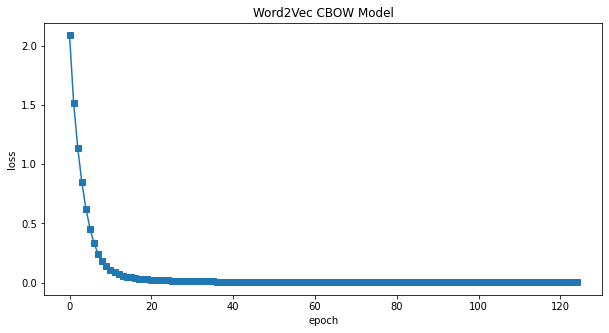

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(lst_loss, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec CBOW Model')
plt.show()

### 計算相似詞

In [19]:
def get_similarity(word, top_k, model, word2idx, idx2word):
    W = (model.in_embedding.weight.data + model.out_embedding.weight.data) / 2
    idx = word2idx.get(word, None)
    
    if not idx:
        # 當出現不在字典中的字詞時，顯示Out of vocabulary error
        raise ValueError("Out of vocabulary")
    else:
        x = W[idx]
        
        # 使用cosine相似計算字詞間的相似程度
        cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
        _, topk = torch.topk(cos, top_k+1)
        
        for i in topk[1:]:
            print(f"cosine sim={cos[int(i)]:.3f}: {idx2word[int(i)]}.")

In [20]:
get_similarity('love', 4, model, word2idx, idx2word)

cosine sim=0.356: want.
cosine sim=0.351: msgs.
cosine sim=0.323: camera.
cosine sim=0.301: watch.
